In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import logging
import datetime

In [2]:
def create_logger():
    logger_ = logging.getLogger('main')
    logger_.setLevel(logging.DEBUG)
    fh = logging.FileHandler('simple_lightgbm.log')
    fh.setLevel(logging.DEBUG)
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    formatter = logging.Formatter('[%(levelname)s]%(asctime)s:%(name)s:%(message)s')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)
    # add the handlers to the logger
    logger_.addHandler(fh)
    logger_.addHandler(ch)


def get_logger():
    return logging.getLogger('main')


def lgb_multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False


def multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss


def predict_chunk(df_, clfs_, meta_, features, train_mean):

    df_['flux_ratio_sq'] = np.power(df_['flux'] / df_['flux_err'], 2.0)
    df_['flux_by_flux_ratio_sq'] = df_['flux'] * df_['flux_ratio_sq']

    # Group by object id
    aggs = get_aggregations()

    aggs = get_aggregations()
    aggs['flux_ratio_sq'] = ['sum']
    aggs['flux_by_flux_ratio_sq'] = ['sum']

    new_columns = get_new_columns(aggs)

    agg_ = df_.groupby('object_id').agg(aggs)
    agg_.columns = new_columns

    agg_ = add_features_to_agg(df=agg_)

    # Merge with meta data
    full_test = agg_.reset_index().merge(
        right=meta_,
        how='left',
        on='object_id'
    )

    full_test = full_test.fillna(train_mean)
    # Make predictions
    preds_ = None
    for clf in clfs_:
        if preds_ is None:
            preds_ = clf.predict_proba(full_test[features]) / len(clfs_)
        else:
            preds_ += clf.predict_proba(full_test[features]) / len(clfs_)

    # Compute preds_99 as the proba of class not being any of the others
    # preds_99 = 0.1 gives 1.769
    preds_99 = np.ones(preds_.shape[0])
    for i in range(preds_.shape[1]):
        preds_99 *= (1 - preds_[:, i])

    # Create DataFrame from predictions
    preds_df_ = pd.DataFrame(preds_, columns=['class_' + str(s) for s in clfs_[0].classes_])
    preds_df_['object_id'] = full_test['object_id']
    preds_df_['class_99'] = 0.14 * preds_99 / np.mean(preds_99) 

    print(preds_df_['class_99'].mean())

    del agg_, full_test, preds_
    gc.collect()

    return preds_df_


def save_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(8, 24))
    sns.barplot(x='gain', y='feature', data=importances_.sort_values('mean_gain', ascending=False))
    plt.tight_layout()
    plt.savefig(r'../feat/importances_{}.png'.format(datetime.datetime.now().strftime('%m%d_%H%M')))
    importances_.sort_values('mean_gain', ascending=False).to_csv(r'../feat/feat_rank_{}.csv'.format(datetime.datetime.now().strftime('%m%d_%H%M')), index=False)


def train_classifiers(full_train=None, y=None):

    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    clfs = []
    importances = pd.DataFrame()
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 14,
        'metric': 'multi_logloss',
        'learning_rate': 0.03,
        'subsample': .9,
        'colsample_bytree': .7,
        'reg_alpha': .01,
        'reg_lambda': .01,
        'min_split_gain': 0.01,
        'min_child_weight': 10,
        'n_estimators': 1000,
        'silent': -1,
        'verbose': -1,
        'max_depth': 3
    }
    oof_preds = np.zeros((len(full_train), np.unique(y).shape[0]))
    for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
        trn_x, trn_y = full_train.iloc[trn_], y.iloc[trn_]
        val_x, val_y = full_train.iloc[val_], y.iloc[val_]

        clf = lgb.LGBMClassifier(**lgb_params)
        clf.fit(
            trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=lgb_multi_weighted_logloss,
            verbose=100,
            early_stopping_rounds=50
        )
        oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
        get_logger().info(multi_weighted_logloss(val_y, clf.predict_proba(val_x, num_iteration=clf.best_iteration_)))

        imp_df = pd.DataFrame()
        imp_df['feature'] = full_train.columns
        imp_df['gain'] = clf.feature_importances_
        imp_df['fold'] = fold_ + 1
        importances = pd.concat([importances, imp_df], axis=0, sort=False)

        clfs.append(clf)

    get_logger().info('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=oof_preds))

    return clfs, importances


def get_aggregations():
    return {
        'mjd': ['min', 'max', 'size'],
        'passband': ['mean', 'std', 'var'],  # ''min', 'max', 'mean', 'median', 'std'],
#         'flux': ['min', 'max', 'mean', 'median', 'std'],
        'flux': ['min', 'max', 'mean', 'median', 'std', 'skew'],
        'flux_err': ['min', 'max', 'mean', 'median', 'std'],
        'detected': ['mean'],  # ''min', 'max', 'mean', 'median', 'std'],
    }


def get_new_columns(aggs):
    return [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]


def add_features_to_agg(df):
    df['mjd_diff'] = df['mjd_max'] - df['mjd_min']
    df['flux_diff'] = df['flux_max'] - df['flux_min']
    df['flux_dif2'] = (df['flux_max'] - df['flux_min']) / df['flux_mean']
    df['flux_w_mean'] = df['flux_by_flux_ratio_sq_sum'] / df['flux_ratio_sq_sum']
    df['flux_dif3'] = (df['flux_max'] - df['flux_min']) / df['flux_w_mean']



    del df['mjd_max'], df['mjd_min']

    return df

In [3]:
train = pd.read_csv('../input/training_set.csv')
train.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [13]:
train.mjd.describe()

count    1.421705e+06
mean     6.017921e+04
std      3.092379e+02
min      5.958003e+04
25%      5.989905e+04
50%      6.019331e+04
75%      6.048722e+04
max      6.067436e+04
Name: mjd, dtype: float64

In [76]:
def get_time_endpoints(df):
    t_min = df.mjd.min()
    t_max = df.mjd.max()
    print('Min and Max MJD time : {}, {}'.format(t_min, t_max))
    return t_min, t_max

def add_feats_within_time_interval(int_n, t_min, t_max, df, db):
    print('Number of Intervals :', int_n)
    int_dur = (t_max - t_min)/int_n
    for i in range(int_n):
        
        db_fil = db[(db.mjd>=(t_min+i*int_dur))&(db.mjd<(t_min + (i+1)*int_dur))][['object_id','flux','passband']]
        print('Interval #{}, record quantity: {}'.format(i+1, db_fil.shape[0]))
        
        # interval_#_flux_？
        stats = db_fil.groupby('object_id', as_index=False)['flux'].agg({'interval_{}_flux_mean'.format(i+1):'mean',
                                                                          'interval_{}_flux_std'.format(i+1):'std',
                                                                          'interval_{}_flux_min'.format(i+1):'min',
                                                                          'interval_{}_flux_max'.format(i+1):'max',
                                                                         'interval_{}_flux_skew'.format(i+1):'skew'})
        print('New features added: ',stats.columns.tolist())
        df = df.merge(stats, on='object_id', how='left')
        
        
        # interval_#_band_#_flux_？
#         stats = db_fil.groupby(['object_id','passband'])['flux'].skew().unstack()
#         stats.columns = ['interval_{}_band_{}_flux_skew'.format(i+1, str(col)) for col in stats.columns.tolist()]
#         print('Feats added:',stats.columns.tolist())
#         stats['object_id'] = stats.index    
#         df = df.merge(stats, on='object_id', how='left').fillna(0) 
        
                
    # interval_#_flux_？ 互相做差
#     for key in ['max', 'min', 'mean']:
#     for key in ['max']:
#         key_cols = ['interval_{}_flux_{}'.format(i, key) for i in range(1, int_n+1)]
#         for col in key_cols:
#             subtract_cols = [col_ for col_ in key_cols if col_ < col]
#             for sub_col in subtract_cols:
#                 df['{}_minus_{}'.format(col, sub_col)] = df[col] - df[sub_col]
#                 print('Feature added:', '{}_minus_{}'.format(col, sub_col))
        

    
    return df

In [77]:
meta_train = pd.read_csv('../input/training_set_metadata.csv')
meta_train.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [78]:
def add_band_feats(df, db):
    
    
### 均值
    print('Adding feats for the flux mean per band...')
    stats = db.groupby(['object_id','passband'])['flux'].mean().unstack()
    stats.columns = ['band_' + str(col) + '_flux_mean' for col in stats.columns.tolist()]
    
    # band_#_flux_mean互相减去
    mean_cols = stats.columns.tolist()
    for col in mean_cols:
        subtract_cols = [col_ for col_ in mean_cols if col_ < col]
        for sub_col in subtract_cols:
            stats['{}_minus_{}'.format(col, sub_col)] = stats[col] - stats[sub_col]
      
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0)
    
    
### 标准差    
    print('Adding feats for the flux std per band...')
    stats = db.groupby(['object_id','passband'])['flux'].std().unstack()
    stats.columns = ['band_' + str(col) + '_flux_std' for col in stats.columns.tolist()]
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0)

    
### 偏度    
    print('Adding feats for the flux skew per band...')
    stats = db.groupby(['object_id','passband'])['flux'].skew().unstack()
    stats.columns = ['band_' + str(col) + '_flux_skew' for col in stats.columns.tolist()]
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0) 
    

### 最大值
    print('Adding feats for the flux max per band...')
    stats = db.groupby(['object_id','passband'])['flux'].max().unstack()
    stats.columns = ['band_' + str(col) + '_flux_max' for col in stats.columns.tolist()]
    # band_#_flux_max互相减去
    max_cols = stats.columns.tolist()
    for col in max_cols:
        subtract_cols = [col_ for col_ in max_cols if col_ < col]
        for sub_col in subtract_cols:
            stats['{}_minus_{}'.format(col, sub_col)] = stats[col] - stats[sub_col]
            
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0) 
    

    
### 最小值    
    print('Adding feats for the flux min per band...')
    stats = db.groupby(['object_id','passband'])['flux'].min().unstack()
    stats.columns = ['band_' + str(col) + '_flux_min' for col in stats.columns.tolist()]
    # band_#_flux_min互相做差
    min_cols = stats.columns.tolist()
    for col in min_cols:
        subtract_cols = [col_ for col_ in min_cols if col_ < col]
        for sub_col in subtract_cols:
            stats['{}_minus_{}'.format(col, sub_col)] = stats[col] - stats[sub_col]
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0) 
    

    
    
# ### ......  Mean
#     print('Adding feats for the flux_err mean per band...')
#     stats = db.groupby(['object_id','passband'])['flux_err'].mean().unstack()
#     stats.columns = ['band_' + str(col) + '_flux_err_mean' for col in stats.columns.tolist()]      
#     print('Feats added:',stats.columns.tolist())
#     stats['object_id'] = stats.index    
#     df = df.merge(stats, on='object_id', how='left').fillna(0)
    
    
    
    
### 遍历band_list计算 
    print('Adding feats for the flux (max-min)/mean per band...')
    for band_n in range(6):
        df['band_' + str(band_n) + '_flux_diff1'] = df['band_' + str(band_n) + '_flux_max'] - df['band_' + str(band_n) + '_flux_min']
        df['band_' + str(band_n) + '_flux_diff2'] = df['band_' + str(band_n) + '_flux_diff1']/df['band_' + str(band_n) + '_flux_mean']
        print('Feature added: band_' + str(band_n) + '_flux_diff2')
        
#         df['band_' + str(band_n) + '_flux_err_ratio'] = df['band_' + str(band_n) + '_flux_err_mean']/df['band_' + str(band_n) + '_flux_mean']
#         print('Feature added: band_' + str(band_n) + '_flux_err_ratio')
        
        
        

    


    
    return df

    
#     print('Adding feats for the flux mean per band...')
#     stats = db.groupby(['object_id','passband'])['flux'].mean().unstack()
#     stats['object_id'] = stats.index
#     stats.columns = [str(col) + '_mean' for col in stats.columns.tolist()]
#     df = df.merge(db, on='object_id', how='left').fillna(0)
#     print('Feats added:',stats.columns.tolist())
    
    
    

In [79]:
def add_ratio_col(df):
    df['hostgal_photoz_ratio'] = df['hostgal_photoz_err']/df['hostgal_photoz']
    df['hostgal_photoz_ratio'].fillna(0, inplace=True)
    
    return df

In [80]:
def main():
    train = pd.read_csv('../input/training_set.csv')
    
    # 增加按MJD划分时间统计得到的特征
    mjd_min, mjd_max = get_time_endpoints(train)
    # 增加按MJD划分时间统计得到的特征
    
    
    train['flux_ratio_sq'] = np.power(train['flux'] / train['flux_err'], 2.0)
    train['flux_by_flux_ratio_sq'] = train['flux'] * train['flux_ratio_sq']

    
#     # 增加正负1sigma
#     train['flux_m_err'] = train['flux'] - train['flux_err'] 
#     train['flux_p_err'] = train['flux'] + train['flux_err'] 
#     # 增加正负1sigma

    # train = pd.concat([train, pd.get_dummies(train['passband'], prefix='passband')], axis=1, sort=False)

    aggs = get_aggregations()
    aggs['flux_ratio_sq'] = ['sum']
    aggs['flux_by_flux_ratio_sq'] = ['sum']

    
#     # 增加正负1sigma    
#     aggs['flux_m_err'] = ['sum']
#     aggs['flux_p_err'] = ['sum']
    
#     aggs['flux_m_err'] = ['mean']
#     aggs['flux_p_err'] = ['mean']
#     # 增加正负1sigma
    
    
    # passbands = [f for f in train if 'passband_' in f]
    # get_logger().info('Passband features : {}'.format(passbands))
    # for pb in passbands:
    #     aggs[pb] = ['mean']

    agg_train = train.groupby('object_id').agg(aggs)
    new_columns = get_new_columns(aggs)
    agg_train.columns = new_columns

    agg_train = add_features_to_agg(df=agg_train)
    
    agg_train.head()

#     del train
#     gc.collect()

    meta_train = pd.read_csv('../input/training_set_metadata.csv')
    meta_train.head()
    
    # 增加是否在银河系的特征
#     distmod_min = meta_train.distmod.min()
#     meta_train.distmod.fillna(distmod_min,inplace=True)
#     meta_train['in_MilkyWay'] = 0
#     meta_train[meta_train.in_MilkyWay == 1]
    # 增加是否在银河系的特征

    full_train = agg_train.reset_index().merge(
        right=meta_train,
        how='outer',
        on='object_id'
    )
    
    

    y = full_train['target']
    del full_train['target']
#     del full_train['object_id'], full_train['hostgal_specz']  # , full_train['distmod']
    del full_train['hostgal_specz']  # , full_train['distmod']

    train_mean = full_train.mean(axis=0)
    full_train.fillna(train_mean, inplace=True)
    

    
    # 增加 mean_flux_per_band
    full_train = add_band_feats(full_train, train)
    # 增加 mean_flux_per_band
    
    
    # 增加按MJD划分时间统计得到的特征
    full_train = add_feats_within_time_interval(6, mjd_min, mjd_max, full_train, train)
    # 增加按MJD划分时间统计得到的特征 
    
    # 增加ratio特征
    full_train = add_ratio_col(full_train)
    # 增加ratio特征
    
    
    
    
    
    del full_train['object_id']
        
    del train
    gc.collect()

        
    get_logger().info(full_train.columns)
    clfs, importances = train_classifiers(full_train, y)

    save_importances(importances_=importances)

#     meta_test = pd.read_csv('../input/test_set_metadata.csv')

#     import time

#     start = time.time()
#     chunks = 5000000
#     remain_df = None

#     for i_c, df in enumerate(pd.read_csv('../input/test_set.csv', chunksize=chunks, iterator=True)):
#         # Check object_ids
#         # I believe np.unique keeps the order of group_ids as they appear in the file
#         unique_ids = np.unique(df['object_id'])
#         new_remain_df = df.loc[df['object_id'] == unique_ids[-1]].copy()

#         if remain_df is None:
#             df = df.loc[df['object_id'].isin(unique_ids[:-1])].copy()
#         else:
#             df = pd.concat([remain_df, df.loc[df['object_id'].isin(unique_ids[:-1])]], axis=0)

#         # Create remaining samples df
#         remain_df = new_remain_df

#         preds_df = predict_chunk(df_=df,
#                                  clfs_=clfs,
#                                  meta_=meta_test,
#                                  features=full_train.columns,
#                                  train_mean=train_mean)

#         if i_c == 0:
#             preds_df.to_csv('predictions_v3.csv', header=True, index=False, float_format='%.6f')
#         else:
#             preds_df.to_csv('predictions_v3.csv', header=False, mode='a', index=False, float_format='%.6f')

#         del preds_df
#         gc.collect()

#         if (i_c + 1) % 10 == 0:
#             get_logger().info('%15d done in %5.1f' % (chunks * (i_c + 1), (time.time() - start) / 60))
#             print('%15d done in %5.1f' % (chunks * (i_c + 1), (time.time() - start) / 60))

#     # Compute last object in remain_df

#     preds_df = predict_chunk(df_=remain_df,
#                              clfs_=clfs,
#                              meta_=meta_test,
#                              features=full_train.columns,
#                              train_mean=train_mean)

#     preds_df.to_csv('predictions_v3.csv', header=False, mode='a', index=False, float_format='%.6f')

#     z = pd.read_csv('predictions_v3.csv')

#     z = z.groupby('object_id').mean()

#     z.to_csv('single_predictions_v3.csv', index=True, float_format='%.6f')




Min and Max MJD time : 59580.0343, 60674.363
Adding feats for the flux mean per band...
Feats added: ['band_0_flux_mean', 'band_1_flux_mean', 'band_2_flux_mean', 'band_3_flux_mean', 'band_4_flux_mean', 'band_5_flux_mean', 'band_1_flux_mean_minus_band_0_flux_mean', 'band_2_flux_mean_minus_band_0_flux_mean', 'band_2_flux_mean_minus_band_1_flux_mean', 'band_3_flux_mean_minus_band_0_flux_mean', 'band_3_flux_mean_minus_band_1_flux_mean', 'band_3_flux_mean_minus_band_2_flux_mean', 'band_4_flux_mean_minus_band_0_flux_mean', 'band_4_flux_mean_minus_band_1_flux_mean', 'band_4_flux_mean_minus_band_2_flux_mean', 'band_4_flux_mean_minus_band_3_flux_mean', 'band_5_flux_mean_minus_band_0_flux_mean', 'band_5_flux_mean_minus_band_1_flux_mean', 'band_5_flux_mean_minus_band_2_flux_mean', 'band_5_flux_mean_minus_band_3_flux_mean', 'band_5_flux_mean_minus_band_4_flux_mean']
Adding feats for the flux std per band...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


Feats added: ['band_0_flux_std', 'band_1_flux_std', 'band_2_flux_std', 'band_3_flux_std', 'band_4_flux_std', 'band_5_flux_std']
Adding feats for the flux skew per band...
Feats added: ['band_0_flux_skew', 'band_1_flux_skew', 'band_2_flux_skew', 'band_3_flux_skew', 'band_4_flux_skew', 'band_5_flux_skew']
Adding feats for the flux max per band...
Feats added: ['band_0_flux_max', 'band_1_flux_max', 'band_2_flux_max', 'band_3_flux_max', 'band_4_flux_max', 'band_5_flux_max', 'band_1_flux_max_minus_band_0_flux_max', 'band_2_flux_max_minus_band_0_flux_max', 'band_2_flux_max_minus_band_1_flux_max', 'band_3_flux_max_minus_band_0_flux_max', 'band_3_flux_max_minus_band_1_flux_max', 'band_3_flux_max_minus_band_2_flux_max', 'band_4_flux_max_minus_band_0_flux_max', 'band_4_flux_max_minus_band_1_flux_max', 'band_4_flux_max_minus_band_2_flux_max', 'band_4_flux_max_minus_band_3_flux_max', 'band_5_flux_max_minus_band_0_flux_max', 'band_5_flux_max_minus_band_1_flux_max', 'band_5_flux_max_minus_band_2_flu

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


Feats added: ['band_0_flux_min', 'band_1_flux_min', 'band_2_flux_min', 'band_3_flux_min', 'band_4_flux_min', 'band_5_flux_min', 'band_1_flux_min_minus_band_0_flux_min', 'band_2_flux_min_minus_band_0_flux_min', 'band_2_flux_min_minus_band_1_flux_min', 'band_3_flux_min_minus_band_0_flux_min', 'band_3_flux_min_minus_band_1_flux_min', 'band_3_flux_min_minus_band_2_flux_min', 'band_4_flux_min_minus_band_0_flux_min', 'band_4_flux_min_minus_band_1_flux_min', 'band_4_flux_min_minus_band_2_flux_min', 'band_4_flux_min_minus_band_3_flux_min', 'band_5_flux_min_minus_band_0_flux_min', 'band_5_flux_min_minus_band_1_flux_min', 'band_5_flux_min_minus_band_2_flux_min', 'band_5_flux_min_minus_band_3_flux_min', 'band_5_flux_min_minus_band_4_flux_min']
Adding feats for the flux (max-min)/mean per band...
Feature added: band_0_flux_diff2
Feature added: band_1_flux_diff2
Feature added: band_2_flux_diff2
Feature added: band_3_flux_diff2
Feature added: band_4_flux_diff2
Feature added: band_5_flux_diff2
Number

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:68: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


New features added:  ['object_id', 'interval_1_flux_mean', 'interval_1_flux_std', 'interval_1_flux_min', 'interval_1_flux_max', 'interval_1_flux_skew']
Interval #2, record quantity: 327857
New features added:  ['object_id', 'interval_2_flux_mean', 'interval_2_flux_std', 'interval_2_flux_min', 'interval_2_flux_max', 'interval_2_flux_skew']
Interval #3, record quantity: 183160
New features added:  ['object_id', 'interval_3_flux_mean', 'interval_3_flux_std', 'interval_3_flux_min', 'interval_3_flux_max', 'interval_3_flux_skew']
Interval #4, record quantity: 289238
New features added:  ['object_id', 'interval_4_flux_mean', 'interval_4_flux_std', 'interval_4_flux_min', 'interval_4_flux_max', 'interval_4_flux_skew']
Interval #5, record quantity: 166471
New features added:  ['object_id', 'interval_5_flux_mean', 'interval_5_flux_std', 'interval_5_flux_min', 'interval_5_flux_max', 'interval_5_flux_skew']
Interval #6, record quantity: 347513


[INFO]2018-10-26 14:43:53,217:main:Index(['mjd_size', 'passband_mean', 'passband_std', 'passband_var', 'flux_min',
       'flux_max', 'flux_mean', 'flux_median', 'flux_std', 'flux_skew',
       ...
       'interval_5_flux_std', 'interval_5_flux_min', 'interval_5_flux_max',
       'interval_5_flux_skew', 'interval_6_flux_mean', 'interval_6_flux_std',
       'interval_6_flux_min', 'interval_6_flux_max', 'interval_6_flux_skew',
       'hostgal_photoz_ratio'],
      dtype='object', length=150)
[INFO]2018-10-26 14:43:53,217:main:Index(['mjd_size', 'passband_mean', 'passband_std', 'passband_var', 'flux_min',
       'flux_max', 'flux_mean', 'flux_median', 'flux_std', 'flux_skew',
       ...
       'interval_5_flux_std', 'interval_5_flux_min', 'interval_5_flux_max',
       'interval_5_flux_skew', 'interval_6_flux_mean', 'interval_6_flux_std',
       'interval_6_flux_min', 'interval_6_flux_max', 'interval_6_flux_skew',
       'hostgal_photoz_ratio'],
      dtype='object', length=150)
[INFO]2018

[INFO]2018-10-26 14:43:53,217:main:Index(['mjd_size', 'passband_mean', 'passband_std', 'passband_var', 'flux_min',
       'flux_max', 'flux_mean', 'flux_median', 'flux_std', 'flux_skew',
       ...
       'interval_5_flux_std', 'interval_5_flux_min', 'interval_5_flux_max',
       'interval_5_flux_skew', 'interval_6_flux_mean', 'interval_6_flux_std',
       'interval_6_flux_min', 'interval_6_flux_max', 'interval_6_flux_skew',
       'hostgal_photoz_ratio'],
      dtype='object', length=150)
[INFO]2018-10-26 14:43:53,217:main:Index(['mjd_size', 'passband_mean', 'passband_std', 'passband_var', 'flux_min',
       'flux_max', 'flux_mean', 'flux_median', 'flux_std', 'flux_skew',
       ...
       'interval_5_flux_std', 'interval_5_flux_min', 'interval_5_flux_max',
       'interval_5_flux_skew', 'interval_6_flux_mean', 'interval_6_flux_std',
       'interval_6_flux_min', 'interval_6_flux_max', 'interval_6_flux_skew',
       'hostgal_photoz_ratio'],
      dtype='object', length=150)
[INFO]2018

New features added:  ['object_id', 'interval_6_flux_mean', 'interval_6_flux_std', 'interval_6_flux_min', 'interval_6_flux_max', 'interval_6_flux_skew']
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.787617	training's wloss: 1.01316	valid_1's multi_logloss: 0.867637	valid_1's wloss: 1.19196
[200]	training's multi_logloss: 0.563395	training's wloss: 0.723063	valid_1's multi_logloss: 0.694209	valid_1's wloss: 1.00436
[300]	training's multi_logloss: 0.469033	training's wloss: 0.577213	valid_1's multi_logloss: 0.648509	valid_1's wloss: 0.94533
[400]	training's multi_logloss: 0.408809	training's wloss: 0.481216	valid_1's multi_logloss: 0.629909	valid_1's wloss: 0.924732
[500]	training's multi_logloss: 0.363041	training's wloss: 0.41228	valid_1's multi_logloss: 0.61986	valid_1's wloss: 0.916578
[600]	training's multi_logloss: 0.325363	training's wloss: 0.359662	valid_1's multi_logloss: 0.613171	valid_1's wloss: 0.911058
[700]	training's multi_l

[INFO]2018-10-26 14:44:15,846:main:0.9091155153658586
[INFO]2018-10-26 14:44:15,846:main:0.9091155153658586
[INFO]2018-10-26 14:44:15,846:main:0.9091155153658586
[INFO]2018-10-26 14:44:15,846:main:0.9091155153658586
[INFO]2018-10-26 14:44:15,846:main:0.9091155153658586
[INFO]2018-10-26 14:44:15,846:main:0.9091155153658586
[INFO]2018-10-26 14:44:15,846:main:0.9091155153658586
[INFO]2018-10-26 14:44:15,846:main:0.9091155153658586
[INFO]2018-10-26 14:44:15,846:main:0.9091155153658586
[INFO]2018-10-26 14:44:15,846:main:0.9091155153658586
[INFO]2018-10-26 14:44:15,846:main:0.9091155153658586
[INFO]2018-10-26 14:44:15,846:main:0.9091155153658586
[INFO]2018-10-26 14:44:15,846:main:0.9091155153658586
[INFO]2018-10-26 14:44:15,846:main:0.9091155153658586
[INFO]2018-10-26 14:44:15,846:main:0.9091155153658586
[INFO]2018-10-26 14:44:15,846:main:0.9091155153658586
[INFO]2018-10-26 14:44:15,846:main:0.9091155153658586
[INFO]2018-10-26 14:44:15,846:main:0.9091155153658586
[INFO]2018-10-26 14:44:15,84

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.783744	training's wloss: 0.996564	valid_1's multi_logloss: 0.867496	valid_1's wloss: 1.19964
[200]	training's multi_logloss: 0.560406	training's wloss: 0.708424	valid_1's multi_logloss: 0.699112	valid_1's wloss: 1.02318
[300]	training's multi_logloss: 0.464113	training's wloss: 0.558306	valid_1's multi_logloss: 0.654886	valid_1's wloss: 0.967762
[400]	training's multi_logloss: 0.4032	training's wloss: 0.465382	valid_1's multi_logloss: 0.639698	valid_1's wloss: 0.963714
Early stopping, best iteration is:
[363]	training's multi_logloss: 0.423556	training's wloss: 0.495819	valid_1's multi_logloss: 0.643841	valid_1's wloss: 0.961893


[INFO]2018-10-26 14:44:29,959:main:0.961893064550197
[INFO]2018-10-26 14:44:29,959:main:0.961893064550197
[INFO]2018-10-26 14:44:29,959:main:0.961893064550197
[INFO]2018-10-26 14:44:29,959:main:0.961893064550197
[INFO]2018-10-26 14:44:29,959:main:0.961893064550197
[INFO]2018-10-26 14:44:29,959:main:0.961893064550197
[INFO]2018-10-26 14:44:29,959:main:0.961893064550197
[INFO]2018-10-26 14:44:29,959:main:0.961893064550197
[INFO]2018-10-26 14:44:29,959:main:0.961893064550197
[INFO]2018-10-26 14:44:29,959:main:0.961893064550197
[INFO]2018-10-26 14:44:29,959:main:0.961893064550197
[INFO]2018-10-26 14:44:29,959:main:0.961893064550197
[INFO]2018-10-26 14:44:29,959:main:0.961893064550197
[INFO]2018-10-26 14:44:29,959:main:0.961893064550197
[INFO]2018-10-26 14:44:29,959:main:0.961893064550197
[INFO]2018-10-26 14:44:29,959:main:0.961893064550197
[INFO]2018-10-26 14:44:29,959:main:0.961893064550197
[INFO]2018-10-26 14:44:29,959:main:0.961893064550197
[INFO]2018-10-26 14:44:29,959:main:0.961893064

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.779564	training's wloss: 1.00603	valid_1's multi_logloss: 0.883499	valid_1's wloss: 1.17127
[200]	training's multi_logloss: 0.555733	training's wloss: 0.712942	valid_1's multi_logloss: 0.720541	valid_1's wloss: 0.987066
[300]	training's multi_logloss: 0.458254	training's wloss: 0.559796	valid_1's multi_logloss: 0.675822	valid_1's wloss: 0.924499
[400]	training's multi_logloss: 0.395961	training's wloss: 0.461502	valid_1's multi_logloss: 0.658487	valid_1's wloss: 0.91159
Early stopping, best iteration is:
[435]	training's multi_logloss: 0.378837	training's wloss: 0.435245	valid_1's multi_logloss: 0.654249	valid_1's wloss: 0.910114


[INFO]2018-10-26 14:44:46,818:main:0.9101140655703409
[INFO]2018-10-26 14:44:46,818:main:0.9101140655703409
[INFO]2018-10-26 14:44:46,818:main:0.9101140655703409
[INFO]2018-10-26 14:44:46,818:main:0.9101140655703409
[INFO]2018-10-26 14:44:46,818:main:0.9101140655703409
[INFO]2018-10-26 14:44:46,818:main:0.9101140655703409
[INFO]2018-10-26 14:44:46,818:main:0.9101140655703409
[INFO]2018-10-26 14:44:46,818:main:0.9101140655703409
[INFO]2018-10-26 14:44:46,818:main:0.9101140655703409
[INFO]2018-10-26 14:44:46,818:main:0.9101140655703409
[INFO]2018-10-26 14:44:46,818:main:0.9101140655703409
[INFO]2018-10-26 14:44:46,818:main:0.9101140655703409
[INFO]2018-10-26 14:44:46,818:main:0.9101140655703409
[INFO]2018-10-26 14:44:46,818:main:0.9101140655703409
[INFO]2018-10-26 14:44:46,818:main:0.9101140655703409
[INFO]2018-10-26 14:44:46,818:main:0.9101140655703409
[INFO]2018-10-26 14:44:46,818:main:0.9101140655703409
[INFO]2018-10-26 14:44:46,818:main:0.9101140655703409
[INFO]2018-10-26 14:44:46,81

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.786151	training's wloss: 1.00468	valid_1's multi_logloss: 0.860265	valid_1's wloss: 1.17167
[200]	training's multi_logloss: 0.562444	training's wloss: 0.710494	valid_1's multi_logloss: 0.688746	valid_1's wloss: 0.999916
[300]	training's multi_logloss: 0.466732	training's wloss: 0.563541	valid_1's multi_logloss: 0.640778	valid_1's wloss: 0.956253
[400]	training's multi_logloss: 0.405566	training's wloss: 0.468688	valid_1's multi_logloss: 0.620763	valid_1's wloss: 0.944056
[500]	training's multi_logloss: 0.35846	training's wloss: 0.400963	valid_1's multi_logloss: 0.610629	valid_1's wloss: 0.940076
Early stopping, best iteration is:
[502]	training's multi_logloss: 0.357676	training's wloss: 0.39978	valid_1's multi_logloss: 0.610407	valid_1's wloss: 0.939891


[INFO]2018-10-26 14:45:05,284:main:0.9398905596700153
[INFO]2018-10-26 14:45:05,284:main:0.9398905596700153
[INFO]2018-10-26 14:45:05,284:main:0.9398905596700153
[INFO]2018-10-26 14:45:05,284:main:0.9398905596700153
[INFO]2018-10-26 14:45:05,284:main:0.9398905596700153
[INFO]2018-10-26 14:45:05,284:main:0.9398905596700153
[INFO]2018-10-26 14:45:05,284:main:0.9398905596700153
[INFO]2018-10-26 14:45:05,284:main:0.9398905596700153
[INFO]2018-10-26 14:45:05,284:main:0.9398905596700153
[INFO]2018-10-26 14:45:05,284:main:0.9398905596700153
[INFO]2018-10-26 14:45:05,284:main:0.9398905596700153
[INFO]2018-10-26 14:45:05,284:main:0.9398905596700153
[INFO]2018-10-26 14:45:05,284:main:0.9398905596700153
[INFO]2018-10-26 14:45:05,284:main:0.9398905596700153
[INFO]2018-10-26 14:45:05,284:main:0.9398905596700153
[INFO]2018-10-26 14:45:05,284:main:0.9398905596700153
[INFO]2018-10-26 14:45:05,284:main:0.9398905596700153
[INFO]2018-10-26 14:45:05,284:main:0.9398905596700153
[INFO]2018-10-26 14:45:05,28

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.783465	training's wloss: 0.997828	valid_1's multi_logloss: 0.86818	valid_1's wloss: 1.20361
[200]	training's multi_logloss: 0.563037	training's wloss: 0.713114	valid_1's multi_logloss: 0.697365	valid_1's wloss: 1.01858
[300]	training's multi_logloss: 0.467712	training's wloss: 0.56446	valid_1's multi_logloss: 0.649366	valid_1's wloss: 0.957321
[400]	training's multi_logloss: 0.407939	training's wloss: 0.47049	valid_1's multi_logloss: 0.631436	valid_1's wloss: 0.938713
[500]	training's multi_logloss: 0.362239	training's wloss: 0.403364	valid_1's multi_logloss: 0.622779	valid_1's wloss: 0.931073
Early stopping, best iteration is:
[548]	training's multi_logloss: 0.343141	training's wloss: 0.376066	valid_1's multi_logloss: 0.619737	valid_1's wloss: 0.929423


[INFO]2018-10-26 14:45:24,948:main:0.9294227792566427
[INFO]2018-10-26 14:45:24,948:main:0.9294227792566427
[INFO]2018-10-26 14:45:24,948:main:0.9294227792566427
[INFO]2018-10-26 14:45:24,948:main:0.9294227792566427
[INFO]2018-10-26 14:45:24,948:main:0.9294227792566427
[INFO]2018-10-26 14:45:24,948:main:0.9294227792566427
[INFO]2018-10-26 14:45:24,948:main:0.9294227792566427
[INFO]2018-10-26 14:45:24,948:main:0.9294227792566427
[INFO]2018-10-26 14:45:24,948:main:0.9294227792566427
[INFO]2018-10-26 14:45:24,948:main:0.9294227792566427
[INFO]2018-10-26 14:45:24,948:main:0.9294227792566427
[INFO]2018-10-26 14:45:24,948:main:0.9294227792566427
[INFO]2018-10-26 14:45:24,948:main:0.9294227792566427
[INFO]2018-10-26 14:45:24,948:main:0.9294227792566427
[INFO]2018-10-26 14:45:24,948:main:0.9294227792566427
[INFO]2018-10-26 14:45:24,948:main:0.9294227792566427
[INFO]2018-10-26 14:45:24,948:main:0.9294227792566427
[INFO]2018-10-26 14:45:24,948:main:0.9294227792566427
[INFO]2018-10-26 14:45:24,94

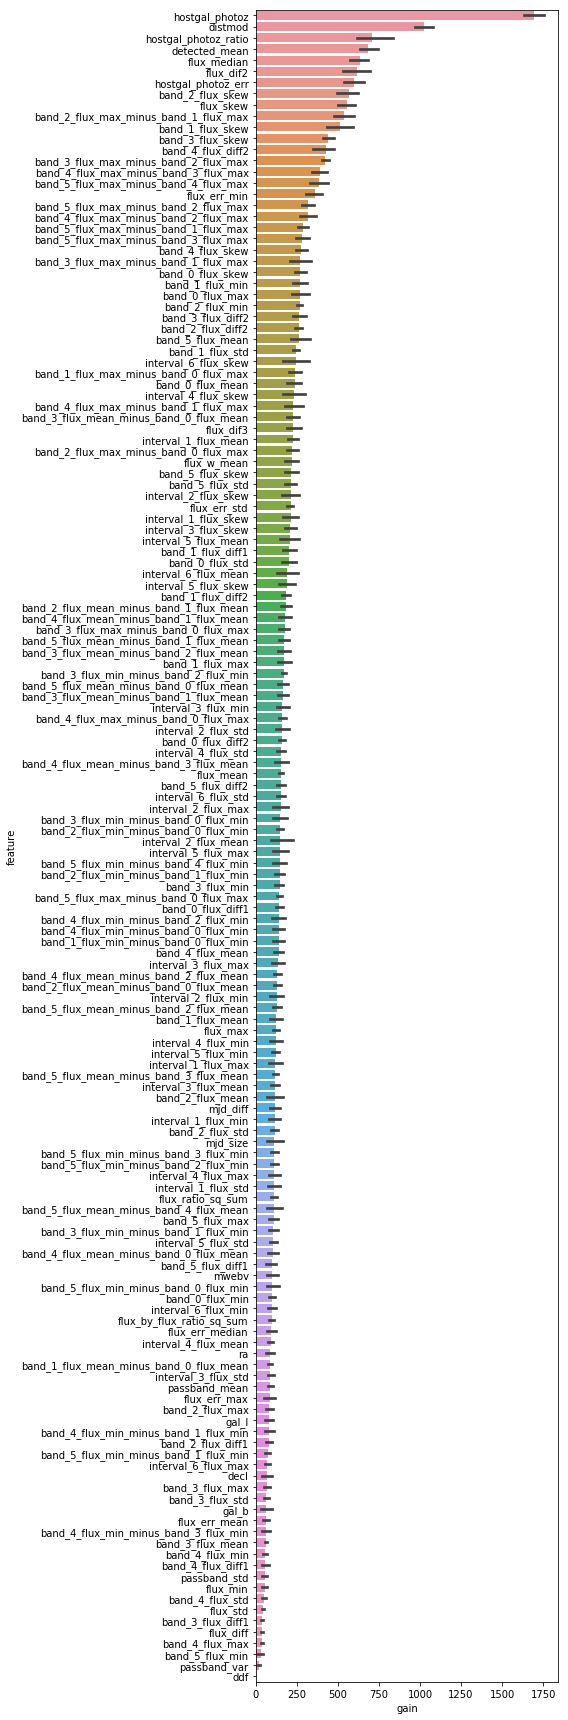

In [81]:
gc.enable()
create_logger()
try:
    main()
except Exception:
    get_logger().exception('Unexpected Exception Occured')
    raise